**Intelligence Transportation System**

**Importing libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # used for plots etc
import seaborn as sns # layer above then matplotlib
import datetime
import tensorflow # import and use deep learning and ML models especially neural networks CNN etc
import tensorflow as tf
from tensorflow import keras # Keras is a high-level neural network library that runs on top of TensorFlow.
from keras import callbacks #an object that can perform actions at various stages of training at the start or end of an epoch,
#Keras layers are the primary building block of Keras models. Each layer receives input information, do some computation and
#finally output the transformed information. The output of one layer will flow into the next layer as its input.
from tensorflow.keras import layers, Sequential, callbacks
#Conv2D is a function provided by the Keras library that
#performs a 2D convolution operation on input images. Conv2D is designed to learn
#features or patterns in an input image by applying a set of learnable filters on the input image.
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import warnings
warnings.filterwarnings("ignore")

There are three different APIs available in Keras to build deep learning models.

Sequential model (API)
Functional API
Model subclassing
When creating a Sequential model, first we instantiate an empty Sequential model using the Sequentialclass and then add layers to that model one by one using the addmethod.

**Loading Data**

In [2]:
#Loading Data
dataset = pd.read_csv("traffic.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
data = dataset.copy()

In [4]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info

<bound method DataFrame.info of                  DateTime  Junction  Vehicles
0     2015-11-01 00:00:00         1        15
1     2015-11-01 01:00:00         1        13
2     2015-11-01 02:00:00         1        10
3     2015-11-01 03:00:00         1         7
4     2015-11-01 04:00:00         1         9
...                   ...       ...       ...
48115 2017-06-30 19:00:00         4        11
48116 2017-06-30 20:00:00         4        30
48117 2017-06-30 21:00:00         4        16
48118 2017-06-30 22:00:00         4        22
48119 2017-06-30 23:00:00         4        12

[48120 rows x 3 columns]>

Text(0.5, 0, 'Date')

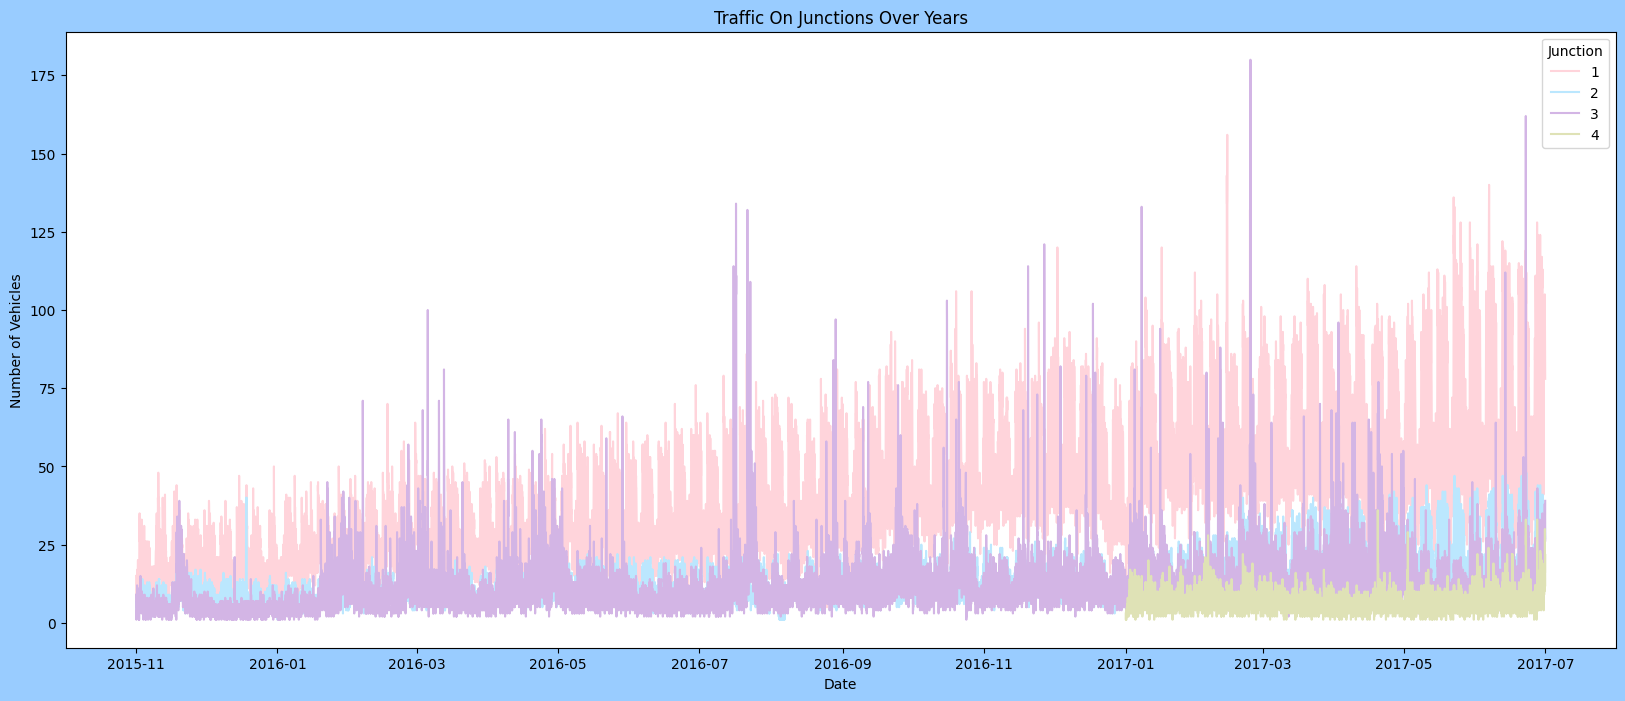

In [5]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
#This parameter adds color differentiation to the plot based on the values in the "Junction" column.
#Each unique value in the "Junction" column will be represented by a different color.
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [6]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
#%A is a format code that represents the full weekday name.
#For example, if a date falls on a Monday, %A will output "Monday" B = Months, .
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


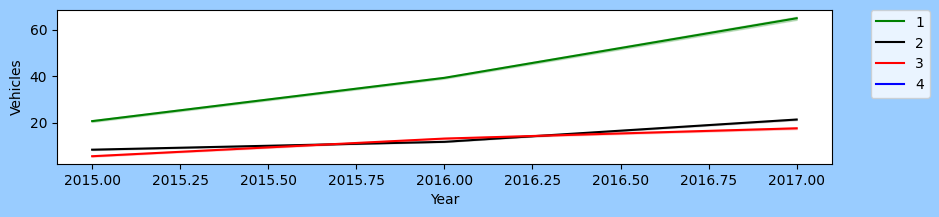

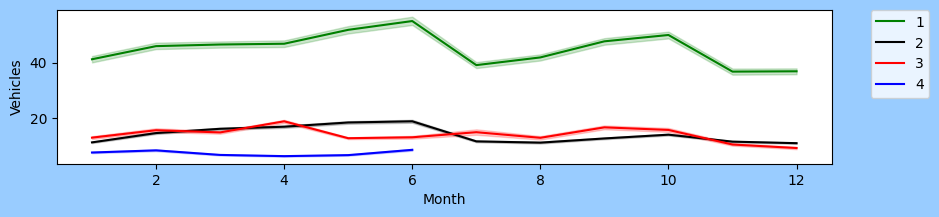

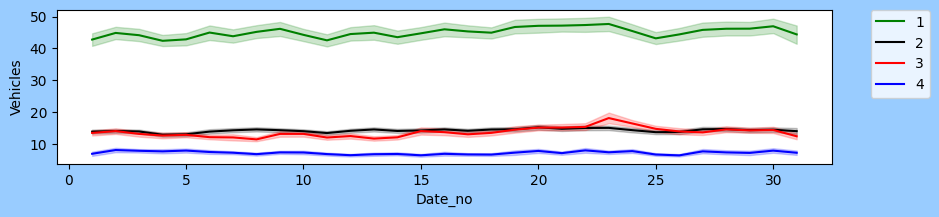

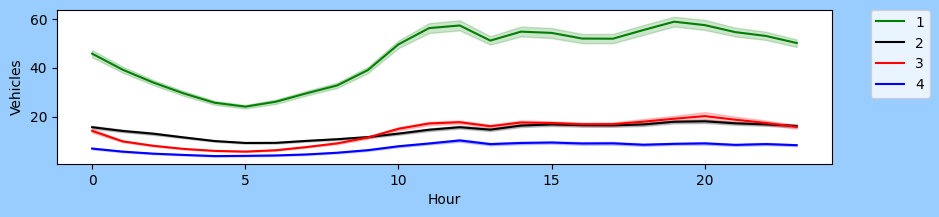

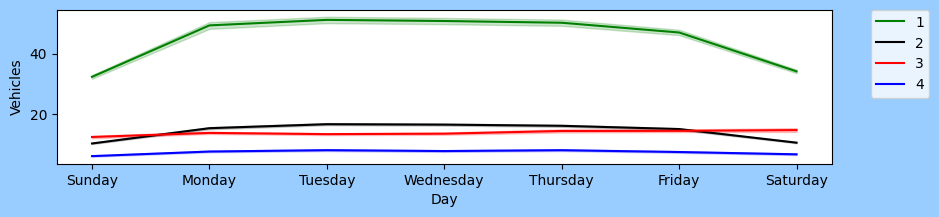

In [7]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]
colors = [ "green","black","red","blue"]
for i in new_features:
    plt.figure(figsize=(10, 2),facecolor="#99ccff")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

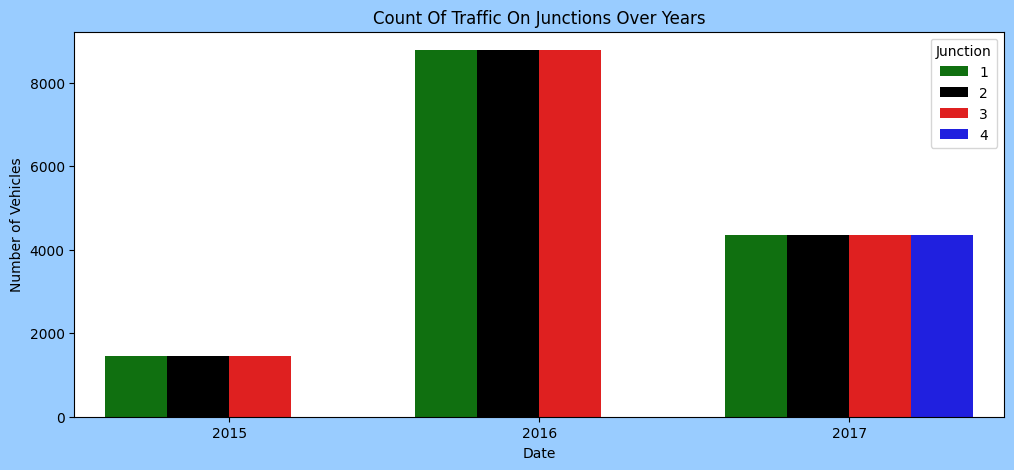

In [8]:
plt.figure(figsize=(12,5),facecolor="#99ccff")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

By using the pivot operation, you transform this long-format data into a wide-format where the date-time entries become the index, and each junction gets its own column. This makes it more convenient to compare traffic data across junctions at the same timestamp.

In [9]:
#Pivoting data fron junction
df_J = data.pivot(columns="Junction", index="DateTime")
print(df_J)
df_J.describe()

                    Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]


Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

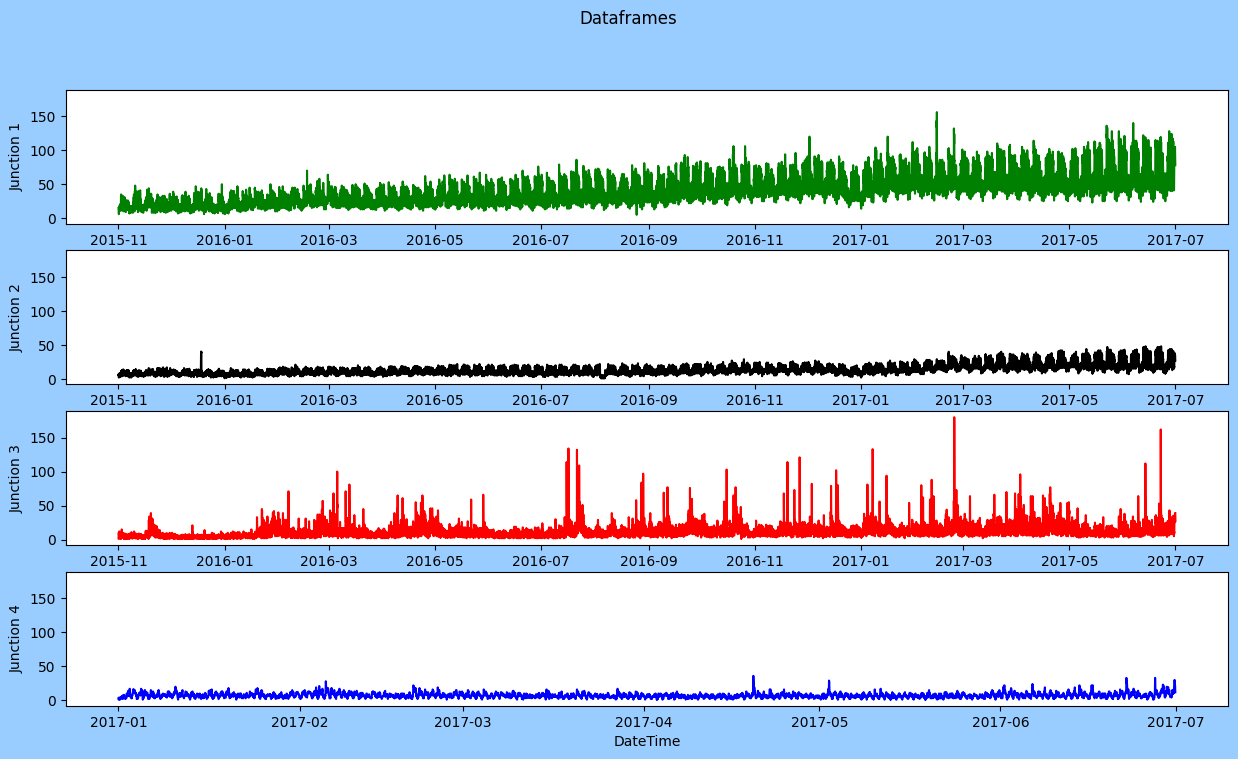

In [10]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):

  #sharey=True ensures that the y-axis scales are consistent across all four subplots,
  #making it easier to compare and analyze the data.

    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#99ccff", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes")

Normalization is a technique used to scale numerical variables to a standard range, often between 0 and 1. This is particularly useful when working with models that are sensitive to the scale of input features, such as neural networks.
 Differencing is a method to remove trends or seasonality in time series data. It involves subtracting the value at a previous time step from the value at the current time step.
 The typical goal is to make the time series data stationary, meaning that its statistical properties do not change over time. Stationary data is often easier to model and analyze, especially when using techniques like autoregressive integrated moving average (ARIMA) or recurrent neural networks (RNNs).

In [11]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

For Junction one, I will be taking a difference of weekly values.
For junction two, The difference of consecutive days is a better choice
For Junctions three and four, the difference of the hourly values will serve the purpose.

In [12]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

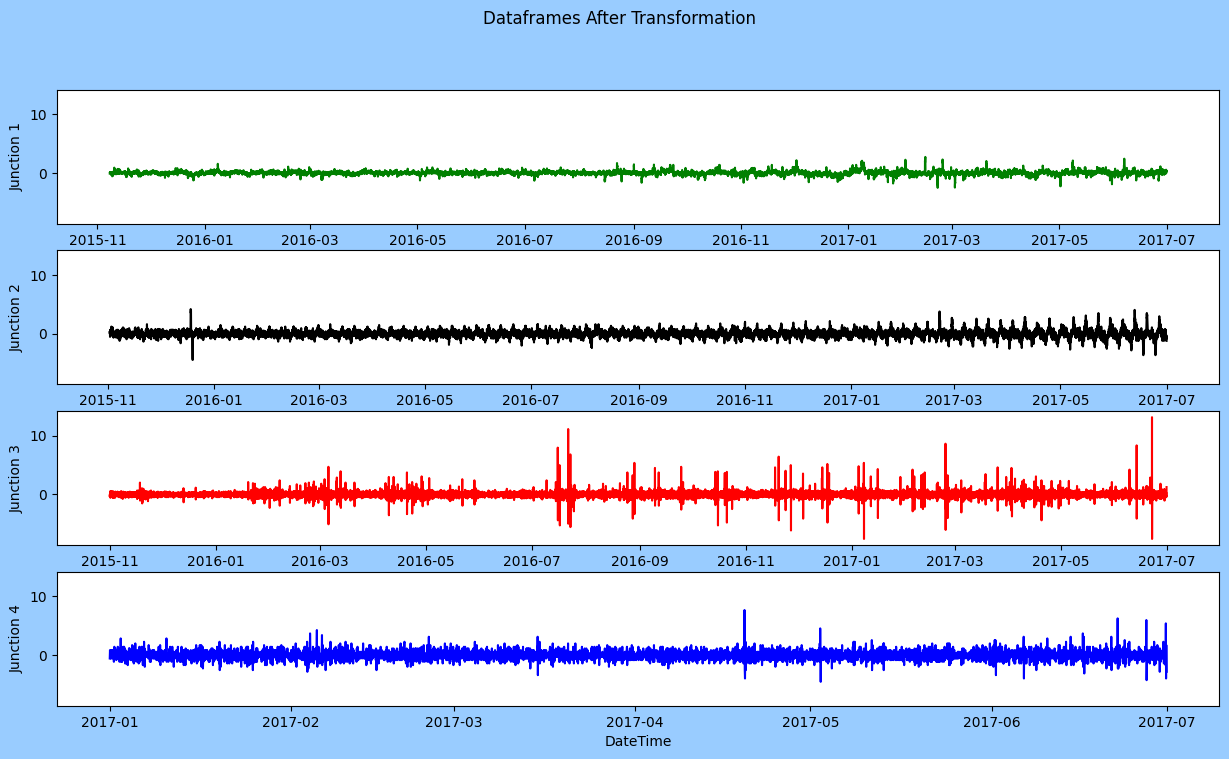

In [13]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [14]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.70)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets

J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

initial_learning_rate: This is the starting learning rate at the beginning of training. If you increase it, the model may initially learn faster, but it could be more prone to overshooting and divergence. If you decrease it, the model may take longer to converge.

decay_steps: This parameter determines how often the learning rate will decay. If you increase decay_steps, the learning rate will decrease more slowly. If you decrease it, the learning rate will decay more quickly. This parameter is often set based on the total number of training steps.

decay_rate: The decay rate controls the rate at which the learning rate decreases. A higher decay rate results in a faster decrease in the learning rate, while a lower decay rate slows down the decrease. If you set it close to 1.0, the learning rate will decrease more gradually, whereas a lower value will make it decrease more sharply.
initial_learning_rate=0.01: At the beginning of training, your model will start with a learning rate of 0.01. This is the size of the steps your optimization algorithm takes to minimize the error.

decay_steps=10000: After every 10,000 steps (or batches of training data), the learning rate will decrease. This is like saying, "Okay, we've been learning for a while; let's take smaller steps now."

decay_rate=0.9: When the learning rate decreases, it will be multiplied by 0.9. So, if the current learning rate is 0.01, after 10,000 steps, it will become 0.01 * 0.9 = 0.009. After the next 10,000 steps, it will become 0.009 * 0.9 = 0.0081, and so on.

In [15]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
#This is the starting learning rate for your model. In neural networks, the learning rate is a hyperparameter 
# that determines the size of the steps taken during the optimization process. A higher learning rate can make the
# model converge faster, but it may overshoot the minimum. A lower learning rate makes the optimization process 
# more stable but slower.

#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning.

#GRU can also be considered as a variation on the LSTM

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))

#The return_sequences parameter in a recurrent layer, such as the Gated Recurrent Unit (GRU) in a neural network,
# determines whether the layer should return the full sequence of outputs for each input sequence or just the output at the last time step

#The choice of the number of neurons in each layer is often a hyperparameter that depends on the specific task
#, the complexity of the data, and considerations such as computational resources and training time.
#More neurons in a layer allow the network to learn more complex representations, but it also increases
# the number of parameters, which may lead to overfitting if not controlled

#Dropout(0.2): This introduces dropout to the model, randomly setting 20% of the input units to 0
#at each update during training time. Dropout is
# a regularization technique used to prevent overfitting by reducing interdependence between units.

    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh')) #no return sequence
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Adds a dense layer with one unit, which is common for regression tasks. The model outputs a single value.

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#a variant of the Gradient Descent algorithm that is used for optimizing machine learning models.
#momentum=0.9: Momentum is a parameter that accelerates the optimization process, helping the model converge faster.
#is used to evaluate the model's performance during training. It helps to monitor whether the model is overfitting.
#epochs=50: The number of epochs defines how many times the entire dataset is passed through the neural network for training.
#batch_size=120: During training, the dataset is divided into batches, and this parameter
# determines the number of samples used in each batch.By dividing the dataset into smaller batches, the model
#processes only a subset of the data at a time, reducing the memory requirements and computational load.
# # LSTM Model for the prediction
# def LSTM_model(X_Train, y_Train, X_Test, y_Test):
#     early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)


# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))

#MaxPooling1D: This is a type of pooling layer used in neural networks. In the case of MaxPooling1D, it performs 1D max pooling. Max pooling
# is a down-sampling operation commonly used in convolutional neural networks (CNNs) to reduce the spatial dimensions of the input volume.
#pool_size=2: The pool_size parameter specifies the size of the window over which the max operation is applied. In this case, pool_size=2 means that the max operation is applied over windows of size 2. This effectively reduces the length of the sequence (or time series) by a factor of 2.

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN
#Patience: This parameter says about the number of epochs
#we can wait for before stopping the training process when our val_loss is not improving.
#min_delta- This parameter tells about the lower bound in the monitored value
 #(here it is val_loss) that we can consider as an improvement.
# MLP Model for the prediction
def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)    # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_MLP = model.predict(X_Test)
    return pred_MLP

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#99ccff")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

he main reason why we use sigmoid function is because it exists between (0 to 1). Therefore, it is especially used for models where we have to predict the probability as an output.Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice. tanh is also like logistic sigmoid but better. The range of the tanh function is from (-1 to 1). tanh is also sigmoidal (s - shaped).

In [16]:
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)


print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ1_CNN = CNN_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ1_MLP = MLP_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

#\033: The escape character.
#[1: Select bold text style.
#;34: Set text color to blue.
#m: End the escape sequence for text formatting.
#This text is in blue color: The actual text to be printed.
#\033[0m: Reset text formatting to default.
#31: Red  32: Green  33: Yellow 34: Blue

########------GRU Model------########
Epoch 1/50
84/84 [==============================] - 12s 40ms/step - loss: 0.0609 - val_loss: 0.1128
Epoch 2/50
84/84 [==============================] - 1s 16ms/step - loss: 0.0515 - val_loss: 0.1102
Epoch 3/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0506 - val_loss: 0.1081
Epoch 4/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0504 - val_loss: 0.1061
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0494 - val_loss: 0.1060
Epoch 6/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0485 - val_loss: 0.1021
Epoch 7/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0486 - val_loss: 0.1003
Epoch 8/50
84/84 [==============================] - 1s 15ms/step - loss: 0.0475 - val_loss: 0.0992
Epoch 9/50
84/84 [==============================] - 2s 20ms/step - loss: 0.0465 - val_loss: 0.0974
Epoch 10/50
84/84 [==============================] - 1s 18ms/step - lo

Epoch 26/50: It's showing that the model is currently in the 26th epoch out of the total 50 epochs.

84/84: This typically indicates the number of batches processed in the current epoch. In this case, 84 batches have been processed, and the model has completed one pass through the entire training dataset.

-2s: This might indicate the time taken for this epoch. In this case, it's negative, which seems unusual. It could be a glitch or a specific format used by the training logging.

29ms/step: This shows the average time taken for each training step (batch). In this case, it's 29 milliseconds per step.

loss: 0.0372: This is the training loss for the current epoch. It represents how well the model is performing on the training dataset. The goal is to minimize this value.

val_loss: 0.0753: This is the validation loss for the current epoch. It represents how well the model is performing on a separate validation dataset that it has not seen during training. The goal is to ensure the model generalizes well to new, unseen data.

########------GRU Model------########
The root mean squared error is 0.2762365889786374.


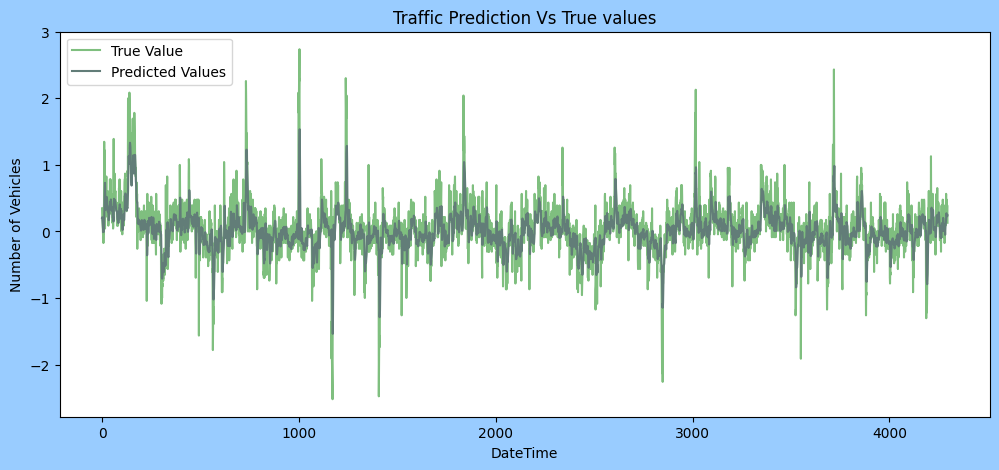


########------CNN Model------########
The root mean squared error is 0.270232230777046.


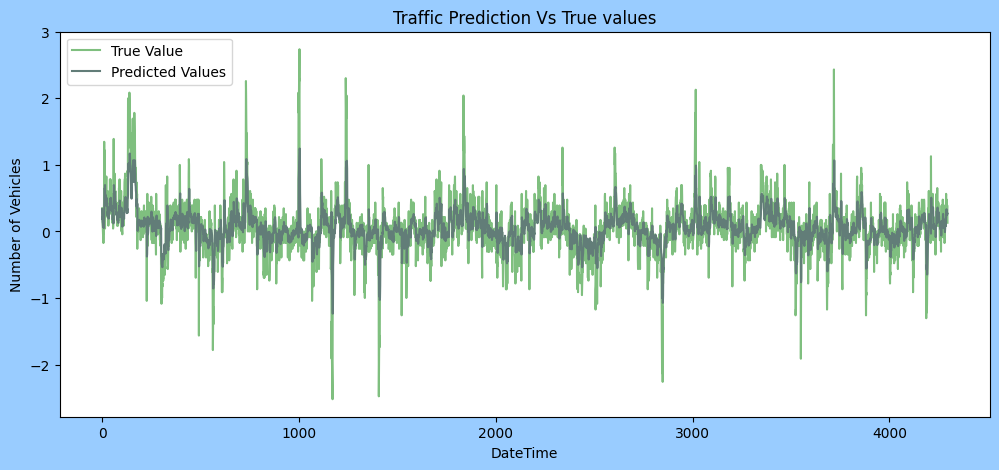


########------MLP Model------########
The root mean squared error is 0.2634726337443102.


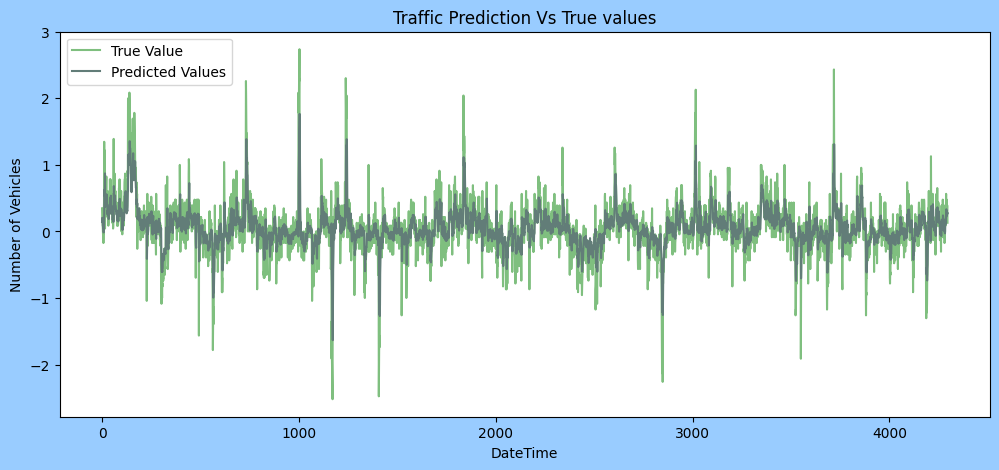


Best Model: MLP - RMSE: 0.2634726337443102



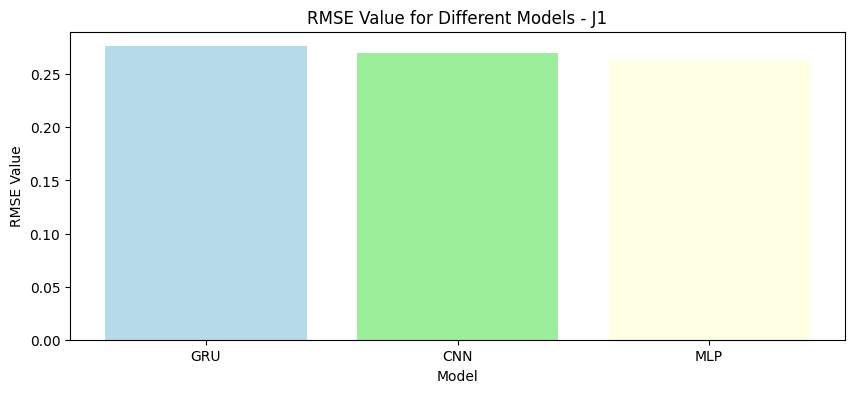

,MODEL,RMSE
0,GRU,0.276237
1,CNN,0.270232
2,MLP,0.263473


In [17]:
# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)


print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)


print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
PredictionsPlot(y_testJ1, PredJ1_MLP, 0)


model_names = [ "GRU","CNN", "MLP"]
rmse_values = [RMSE_J1_GRU, RMSE_J1_CNN, RMSE_J1_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")


best_model_index = rmse_values.index(min(rmse_values))
best_model_name_1 = model_names[best_model_index]
best_model_rmse_1 = rmse_values[best_model_index]


print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_1, best_model_rmse_1))


colors = [ 'lightblue', 'lightgreen', 'lightyellow']
alpha = 0.9
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J1')
plt.show()

display(styled_df)

In [18]:
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

########------GRU Model------########
Epoch 1/50
85/85 [==============================] - 10s 31ms/step - loss: 0.2100 - val_loss: 0.3530
Epoch 2/50
85/85 [==============================] - 1s 15ms/step - loss: 0.1883 - val_loss: 0.3264
Epoch 3/50
85/85 [==============================] - 1s 15ms/step - loss: 0.1827 - val_loss: 0.3054
Epoch 4/50
85/85 [==============================] - 1s 15ms/step - loss: 0.1798 - val_loss: 0.3144
Epoch 5/50
85/85 [==============================] - 1s 15ms/step - loss: 0.1793 - val_loss: 0.2982
Epoch 6/50
85/85 [==============================] - 2s 18ms/step - loss: 0.1771 - val_loss: 0.3008
Epoch 7/50
85/85 [==============================] - 2s 19ms/step - loss: 0.1767 - val_loss: 0.2902
Epoch 8/50
85/85 [==============================] - 1s 15ms/step - loss: 0.1785 - val_loss: 0.2827
Epoch 9/50
85/85 [==============================] - 1s 15ms/step - loss: 0.1758 - val_loss: 0.3036
Epoch 10/50
85/85 [==============================] - 1s 15ms/step - lo

########------GRU Model------########
The root mean squared error is 0.5216972148176142.


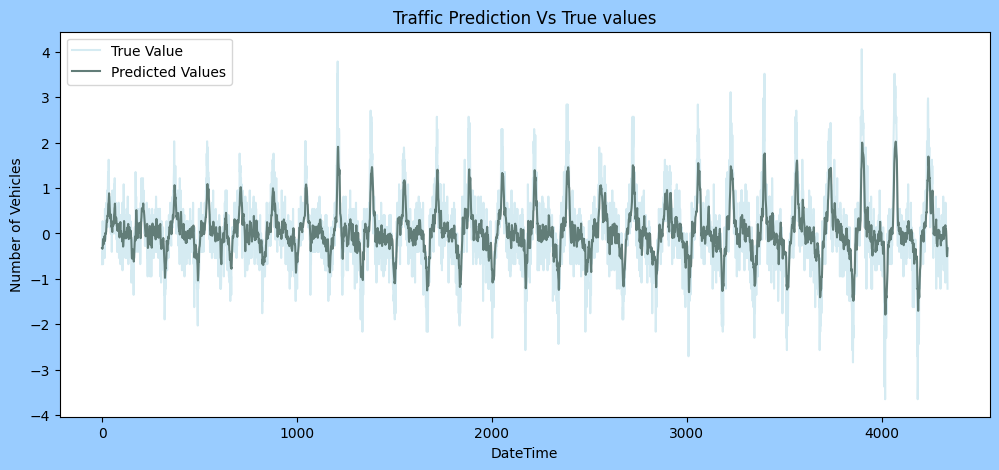


########------CNN Model------########
The root mean squared error is 0.4985064799204991.


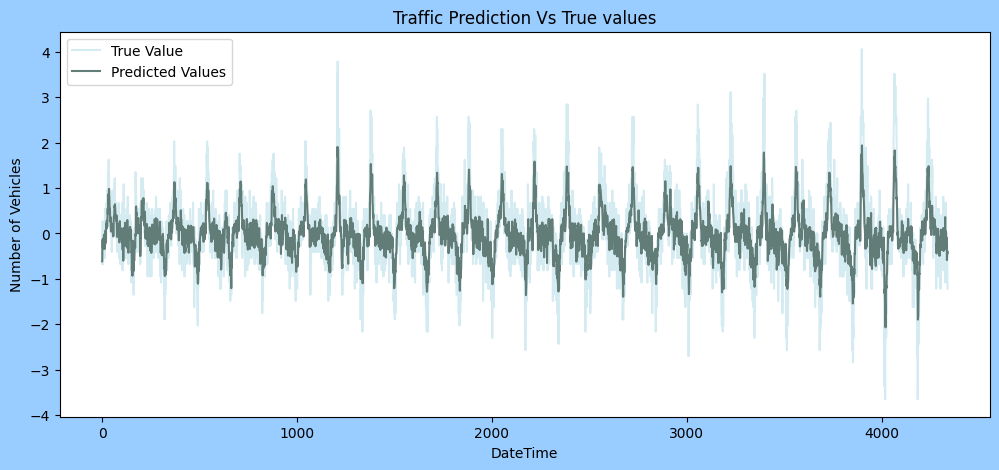


########------MLP Model------########
The root mean squared error is 0.4762962910997823.


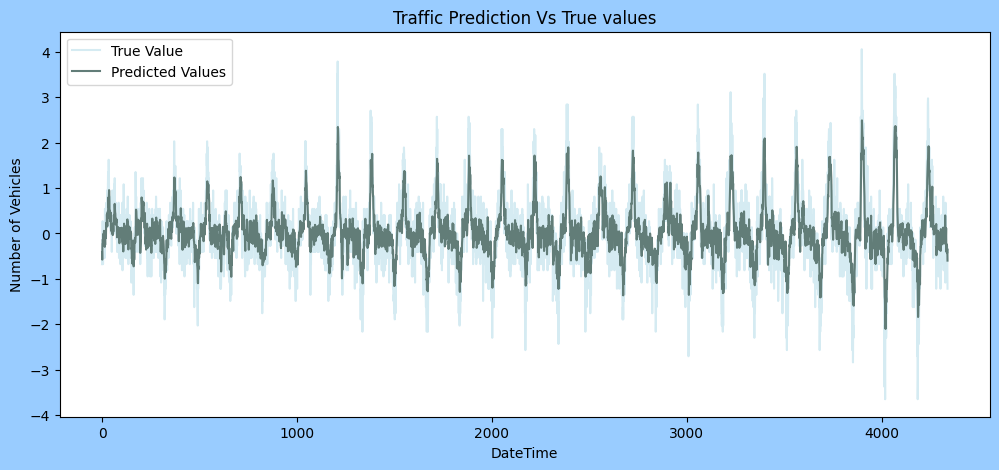


Best Model: MLP - RMSE: 0.4762962910997823



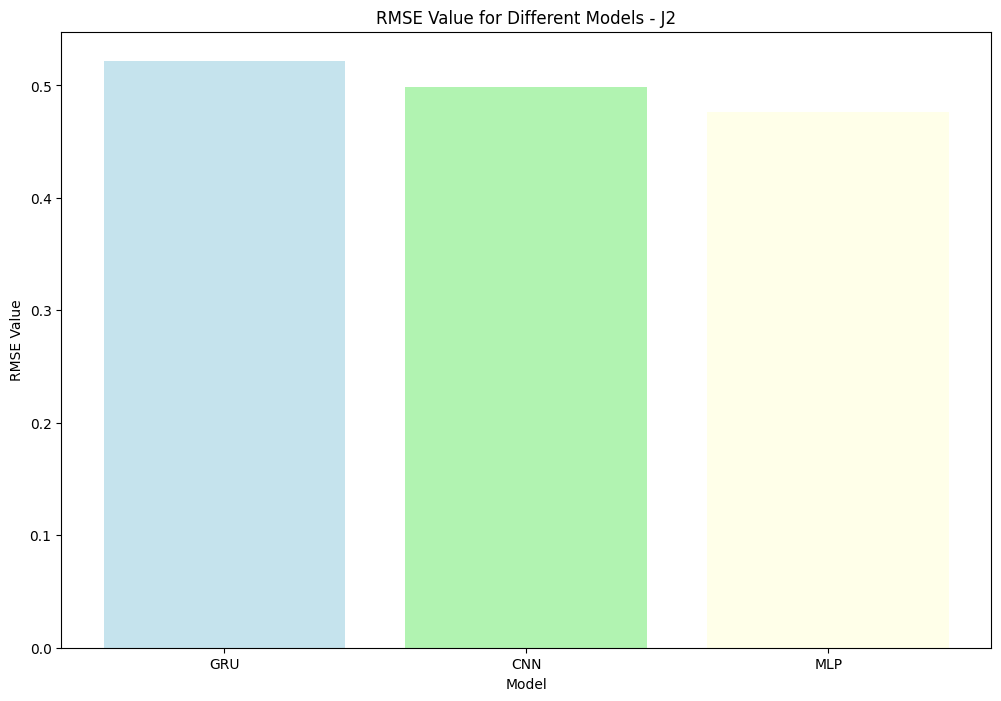

,MODEL,RMSE
0,GRU,0.521697
1,CNN,0.498506
2,MLP,0.476296


In [19]:
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)


print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 0)


print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J2_MLP = RMSE_Value(y_testJ2, PredJ2_MLP)
PredictionsPlot(y_testJ2, PredJ2_MLP, 0)


model_names = [ "GRU", "CNN", "MLP"]
rmse_values = [RMSE_J2_GRU, RMSE_J2_CNN, RMSE_J2_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="Pastel1")


best_model_index = rmse_values.index(min(rmse_values))
best_model_name_2 = model_names[best_model_index]
best_model_rmse_2 = rmse_values[best_model_index]


print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_2, best_model_rmse_2))


colors = ['lightblue', 'lightgreen','lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J2')
plt.show()

display(styled_df)

In [20]:
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ3_MLP = MLP_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

########------GRU Model------########
Epoch 1/50
85/85 [==============================] - 10s 32ms/step - loss: 0.2636 - val_loss: 0.4167
Epoch 2/50
85/85 [==============================] - 1s 15ms/step - loss: 0.2594 - val_loss: 0.4103
Epoch 3/50
85/85 [==============================] - 1s 15ms/step - loss: 0.2557 - val_loss: 0.4076
Epoch 4/50
85/85 [==============================] - 1s 15ms/step - loss: 0.2572 - val_loss: 0.4061
Epoch 5/50
85/85 [==============================] - 1s 15ms/step - loss: 0.2547 - val_loss: 0.4111
Epoch 6/50
85/85 [==============================] - 2s 19ms/step - loss: 0.2552 - val_loss: 0.4043
Epoch 7/50
85/85 [==============================] - 2s 18ms/step - loss: 0.2536 - val_loss: 0.4044
Epoch 8/50
85/85 [==============================] - 1s 15ms/step - loss: 0.2519 - val_loss: 0.4051
Epoch 9/50
85/85 [==============================] - 1s 15ms/step - loss: 0.2526 - val_loss: 0.4007
Epoch 10/50
85/85 [==============================] - 1s 15ms/step - lo

########------GRU Model------########
The root mean squared error is 0.6091206787088923.


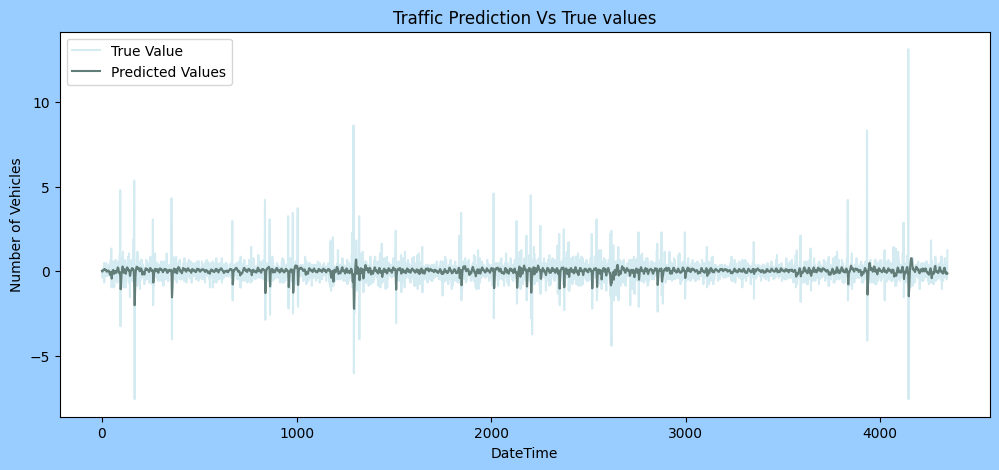


########------CNN Model------########
The root mean squared error is 0.578373145639178.


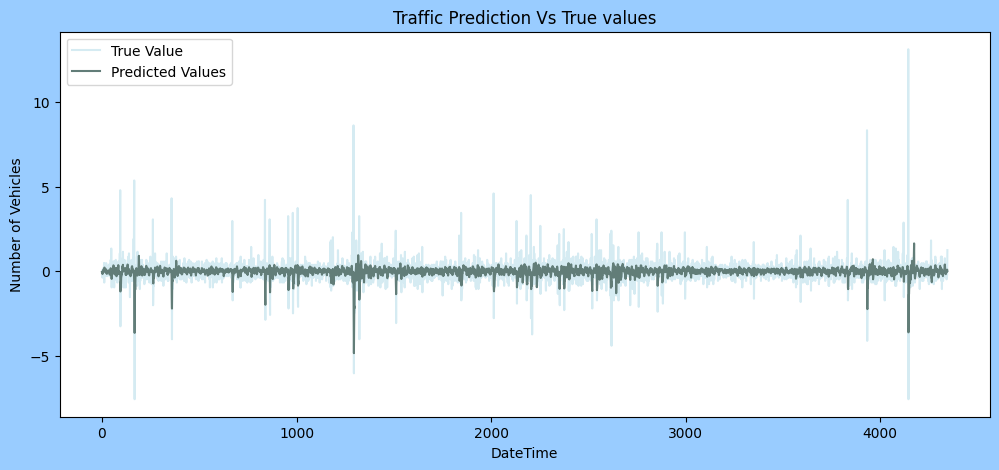


########------MLP Model------########
The root mean squared error is 0.6474492443606764.


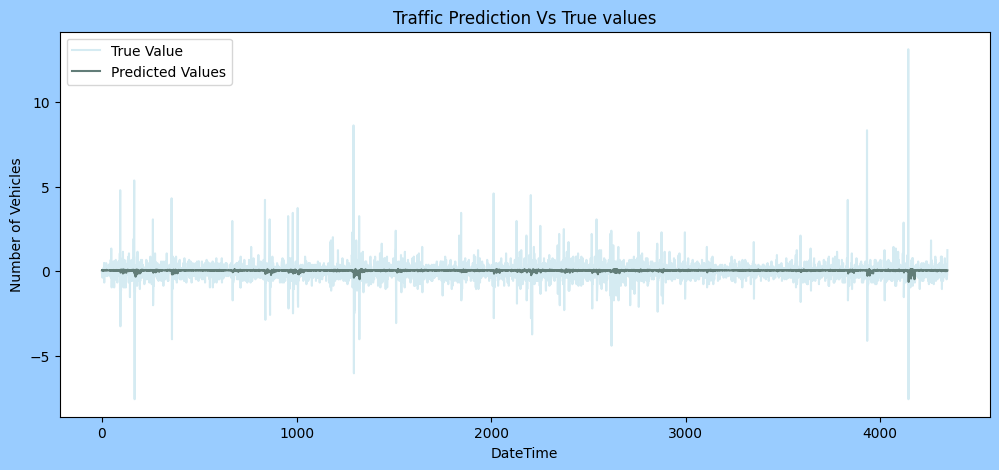


Best Model: CNN - RMSE: 0.578373145639178



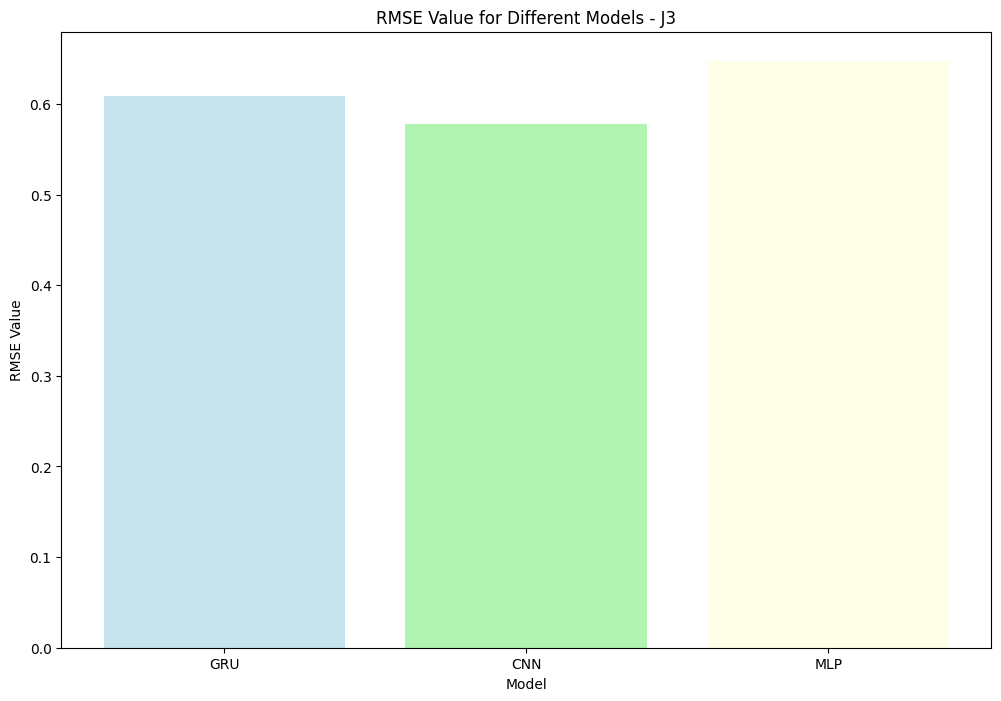

,MODEL,RMSE
0,GRU,0.609121
1,CNN,0.578373
2,MLP,0.647449


In [21]:
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)



print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 0)


print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J3_MLP = RMSE_Value(y_testJ3, PredJ3_MLP)
PredictionsPlot(y_testJ3, PredJ3_MLP, 0)


model_names = [ "GRU","CNN", "MLP"]
rmse_values = [ RMSE_J3_GRU, RMSE_J3_CNN, RMSE_J3_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="Pastel1")


best_model_index = rmse_values.index(min(rmse_values))
best_model_name_3 = model_names[best_model_index]
best_model_rmse_3 = rmse_values[best_model_index]


print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_3, best_model_rmse_3))


colors = [ 'lightblue', 'lightgreen','lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J3')
plt.show()

display(styled_df)

In [22]:

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ4_MLP = MLP_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

########------GRU Model------########
Epoch 1/50
26/26 [==============================] - 9s 74ms/step - loss: 0.6804 - val_loss: 0.8825
Epoch 2/50
26/26 [==============================] - 0s 16ms/step - loss: 0.6852 - val_loss: 0.8832
Epoch 3/50
26/26 [==============================] - 0s 16ms/step - loss: 0.6908 - val_loss: 0.8850
Epoch 4/50
26/26 [==============================] - 0s 15ms/step - loss: 0.6781 - val_loss: 0.8765
Epoch 5/50
26/26 [==============================] - 0s 16ms/step - loss: 0.6825 - val_loss: 0.8779
Epoch 6/50
26/26 [==============================] - 0s 17ms/step - loss: 0.6752 - val_loss: 0.8748
Epoch 7/50
26/26 [==============================] - 0s 15ms/step - loss: 0.6766 - val_loss: 0.8723
Epoch 8/50
26/26 [==============================] - 0s 16ms/step - loss: 0.6722 - val_loss: 0.8718
Epoch 9/50
26/26 [==============================] - 0s 15ms/step - loss: 0.6698 - val_loss: 0.8754
Epoch 10/50
26/26 [==============================] - 0s 15ms/step - los

########------GRU Model------########
The root mean squared error is 0.8798128425450699.


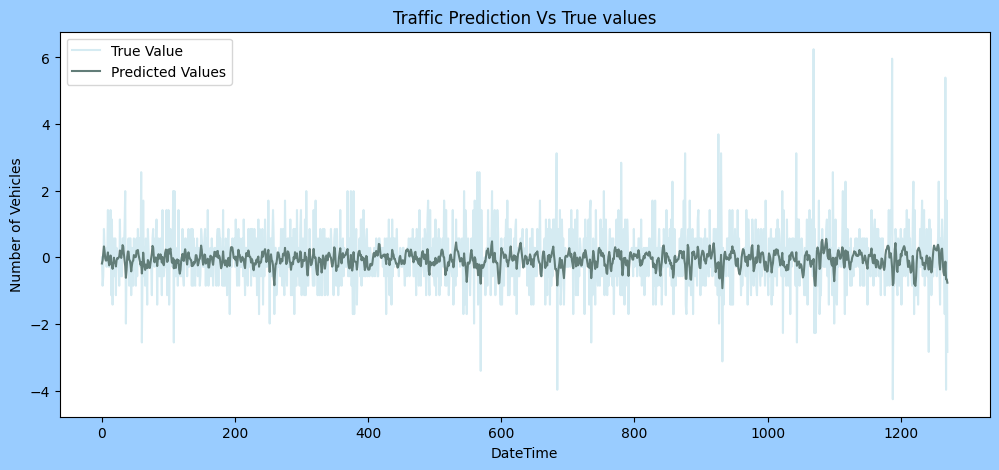


########------CNN Model------########
The root mean squared error is 0.8209307017013359.


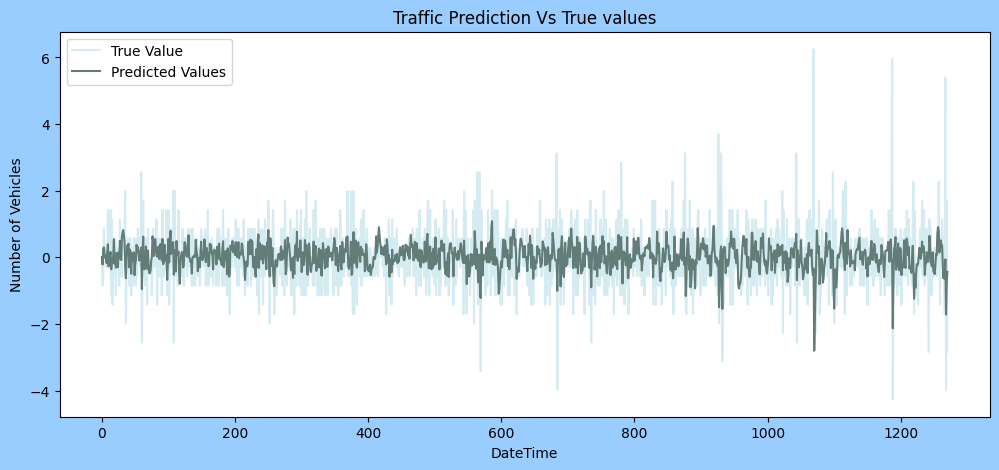


########------MLP Model------########
The root mean squared error is 0.9294304554770239.


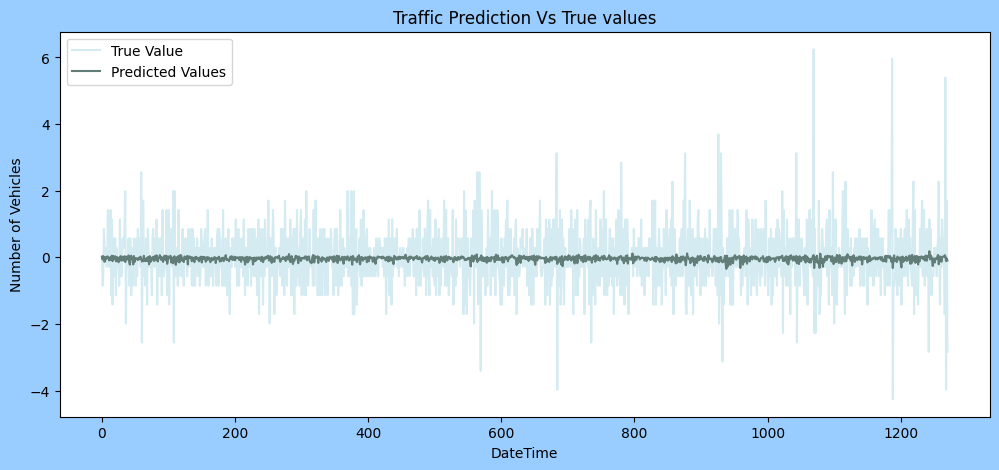


Best Model: CNN - RMSE: 0.8209307017013359



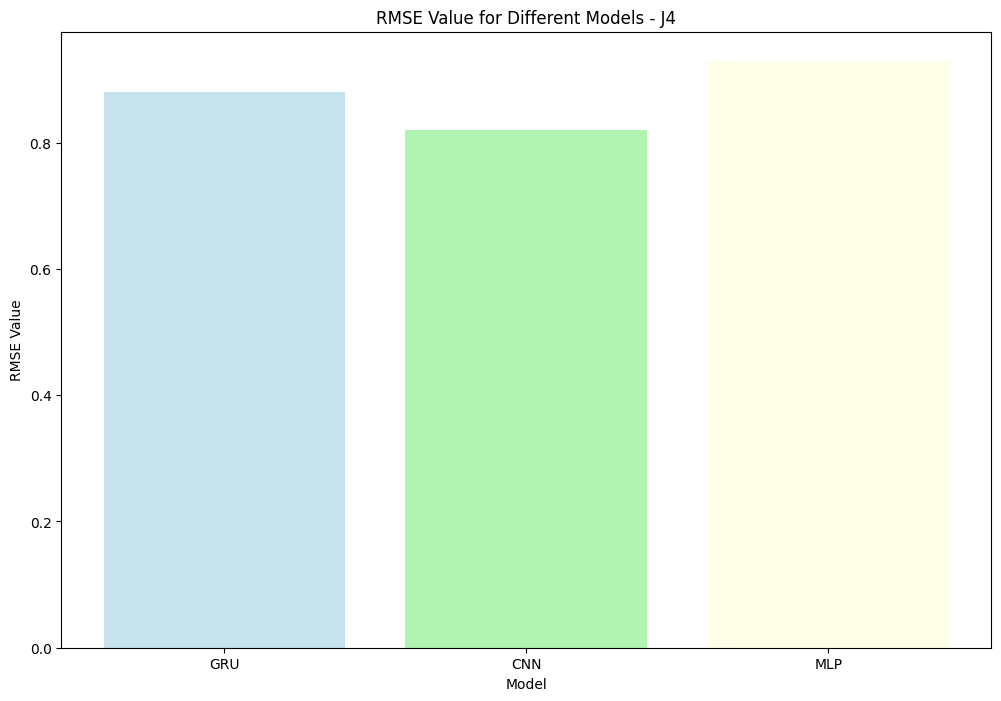

,MODEL,RMSE
0,GRU,0.879813
1,CNN,0.820931
2,MLP,0.929430


In [23]:

print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)


print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 0)


print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J4_MLP = RMSE_Value(y_testJ4, PredJ4_MLP)
PredictionsPlot(y_testJ4, PredJ4_MLP, 0)


model_names = ["GRU","CNN", "MLP"]
rmse_values = [RMSE_J4_GRU, RMSE_J4_CNN, RMSE_J4_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="Pastel1")


best_model_index = rmse_values.index(min(rmse_values))
best_model_name_4 = model_names[best_model_index]
best_model_rmse_4 = rmse_values[best_model_index]


print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_4, best_model_rmse_4))


colors = ['lightblue', 'lightgreen','lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J4')
plt.show()

display(styled_df)

In [24]:
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [best_model_rmse_1, best_model_rmse_2, best_model_rmse_3, best_model_rmse_4]
Model = [best_model_name_1, best_model_name_2, best_model_name_3, best_model_name_4]
list_of_tuples = list(zip(Junctions, RMSE, Model))
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")

,Junction,RMSE,MODEL
0,Junction1,0.263473,MLP
1,Junction2,0.476296,MLP
2,Junction3,0.578373,CNN
3,Junction4,0.820931,CNN
